In [1]:
import copy
import gc
import pickle
import scipy
import warnings
import functools
import pyearth
import scipy
import numpy as np
import ipywidgets as pyw
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm

from itertools import chain, combinations
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, BayesianRidge, RidgeCV, Perceptron, Lasso, LassoCV, SGDRegressor
from sklearn.model_selection import cross_validate, cross_val_score, TimeSeriesSplit, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 61)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None

warnings.simplefilter(action='ignore', category=FutureWarning)

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

gc.collect()

0

In [2]:
def pretty_print_2d(line, matrix):
    print(line)
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))


def display_2d_relationship(df, sig1, sig2, n_quantiles = 10):

    dft = df[['y', sig1, sig2]]
    dft['sig1_decile'] = pd.qcut(dft[sig1], q=n_quantiles, duplicates='drop', precision=3)
    dft['sig2_decile'] = pd.qcut(dft[sig2], q=n_quantiles, duplicates='drop', precision=3)

    results = np.zeros((n_quantiles, n_quantiles))

    for i, sig1_dec in enumerate(dft.sig1_decile.unique()):
        t = dft[dft.sig1_decile == sig1_dec].copy()
        for j, sig2_dec in enumerate(dft.sig2_decile.unique()):
            results[i, j] = np.mean(t[t.sig2_decile == sig2_dec].y)

    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(1, 2, 1)
    cax = ax.matshow(results, origin='upper')
    ax.set_xlabel(sig1)
    ax.set_ylabel(sig2)
    fig.colorbar(cax)
    ax.set_xticks(range(n_quantiles))
    ax.set_xticklabels(['Dec%i' % i for i in range(1, n_quantiles + 1)], rotation=45)
    ax.set_yticks(range(n_quantiles))
    ax.set_yticklabels(['Dec%i' % i for i in range(n_quantiles, 0, -1)], rotation=45)

    X = np.arange(1, n_quantiles + 1)
    Y = np.arange(1, n_quantiles + 1)
    X, Y = np.meshgrid(X, Y)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(Y, X, results, cmap='hot')
    ax.set_xlabel(sig2)
    ax.set_ylabel(sig1)
    ax.set_zlabel('y')
    plt.colorbar(surf)
    ax.set_xticks(range(1, n_quantiles + 1))
    ax.set_xticklabels(['%i' % i for i in range(1, n_quantiles + 1)])
    ax.set_yticks(range(1, n_quantiles + 1))
    ax.set_yticklabels(['%i' % i for i in range(1, n_quantiles + 1)])

    plt.show()


def pretty_print_dict(d):
    for key, value in d.items():
        print('%30s: ' % str(key) + str(['%.6f' % x for x in value]))


def cross_validate_custom(estimator, X, y, w, sig, cv=TimeSeriesSplit(n_splits=3)):
    
    scores = (_fit_and_score(copy.deepcopy(estimator), X, y, w, sig, train, test) for train, test in cv.split(X, y))
    scores = list(zip(*scores))
    
    return {
        'train_score': np.array(scores[0]),
        'test_score': np.array(scores[1]),
        'coefficients': np.array(scores[2])
    }


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def plot_regression(df, sig, w=None, model=LinearRegression(fit_intercept=False), plot=False, print_output=True):
    
    x = df[sig]
    y = df.y
    
    if w is None:
        w = df.y * 0 + 1

    scores = cross_validate_custom(model, x, y, w, sig)
    
    x, y, w = _clean_x_y(x, y, w, sig)
    
    try:
        model.fit(x, y, w_train)
    except:
        model.fit(x, y)
    
    y_pred = model.predict(x)

    if print_output:
        print('Model:       %s' % str(model))
        print('Signal:      %s' % sig)
        print('Train score: %s' % scores['train_score'])
        print('Test score:  %s' % scores['test_score'])
        print('R2 Total:    %.6f' % r2_score(y, y_pred))
        print('Signal mean: %s' % x.mean().values)
        if len(sig) == 1:
            print('Signal !=0:  %s' % len(x[x[sig] != 0]))

        if hasattr(model, 'coef_'):
            pretty_print_2d('Coefficients CV:', scores['coefficients'])
            pretty_print_2d('Coefficients:', [model.coef_])

        print('')

    if len(sig) == 1 and plot:
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        axs[0].plot(x, y, '+')
        axs[0].plot(x, y_pred, 'r-')
        axs[0].set_xlabel('signal')
        axs[0].set_ylabel('y')

        dft = df[[sig[0], 'y']]
        dft['signal decile'] = pd.qcut(dft[sig[0]], q=np.linspace(0, 1., 31), duplicates='drop', precision=3)
        axs[1] = sns.barplot(x='signal decile', y='y', data=dft, ci=None, palette='Spectral')
        plt.xticks(rotation=45)
        
        plt.show()
        
    return scores['test_score']


def _clean_x_y(X, y, w, sig):
    
#     indices_x = (X.vol_y <= 0.8)
#     indices_y = (X.vol_y <= 99999)
    
#     X = X[indices_x & indices_y]
#     y = y[indices_x & indices_y]
#     w = w[indices_x & indices_y]
    
    return X, y, w


def _fit_and_score(estimator, X, y, w, sig, train, test):

    X_train = X.iloc[train]
    y_train = y.iloc[train]
    w_train = w.iloc[train]
    
    X_train, y_train, w_train = _clean_x_y(X_train, y_train, w_train, sig)
    
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    try:
        estimator.fit(X_train, y_train, w_train)
    except:
        estimator.fit(X_train, y_train)

    train_score = r2_score(y_train, estimator.predict(X_train))
    test_score = r2_score(y_test, estimator.predict(X_test))
    
    result = [train_score, test_score]
    
    if hasattr(estimator, 'coef_'):
        result.append(estimator.coef_)
    else:
        result.append(0)
    
    return result


def test_signal(df, signal, model=LinearRegression(fit_intercept=False)):
    df['sig'] = df[signal]
    df['sig_cubed'] = df[signal]**3
    df['sig_shift10'] = df[signal].shift(10).fillna(0)
    df['sig_shift50'] = df[signal].shift(50).fillna(0)
    df['sig_diff'] = df[signal].diff(1).fillna(0)
    df['sig_ewm'] = df[signal].ewm(span=200, adjust=False).mean()
    df['sig_macd'] = df[signal].ewm(span=200, adjust=False).mean() - df[signal].ewm(span=1000, adjust=False).mean()
    df['sig_1'] = df['sig'] - df['sig_ewm']
    df['sig_2'] = ((df['sig'] - df['sig_ewm']) / df['sig_ewm']).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_3'] = ((df['sig'] - df[signal].ewm(span=20, adjust=False).mean()) / df[signal].ewm(span=20, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_4'] = ((df['sig'] - df[signal].ewm(span=50, adjust=False).mean()) / df[signal].ewm(span=50, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_5'] = ((df['sig'] - df[signal].ewm(span=100, adjust=False).mean()) / df[signal].ewm(span=100, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_6'] = ((df['sig'] - df[signal].ewm(span=200, adjust=False).mean()) / df[signal].ewm(span=200, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_7'] = ((df['sig'] - df[signal].ewm(span=500, adjust=False).mean()) / df[signal].ewm(span=500, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_8'] = ((df['sig'] - df[signal].ewm(span=1000, adjust=False).mean()) / df[signal].ewm(span=1000, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_9'] = ((df['sig'] - df[signal].ewm(span=1500, adjust=False).mean()) / df[signal].ewm(span=1500, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    results_sig = plot_regression(df, ['sig'], model=model, plot=False, print_output=False)
    results_sig_nonzero = plot_regression(df[df['sig'] != 0], ['sig'], model=model, plot=False, print_output=False)
    results_sig_cubed = plot_regression(df, ['sig_cubed'], model=model, plot=False, print_output=False)
    results_sig_shift10 = plot_regression(df, ['sig_shift10'], model=model, plot=False, print_output=False)
    results_sig_shift50 = plot_regression(df, ['sig_shift50'], model=model, plot=False, print_output=False)
    results_sig_diff = plot_regression(df, ['sig_diff'], model=model, plot=False, print_output=False)
    results_sig_ewm = plot_regression(df, ['sig_ewm'], model=model, plot=False, print_output=False)
    results_sig_macd = plot_regression(df, ['sig_macd'], model=model, plot=False, print_output=False)
    results_sig_1 = plot_regression(df, ['sig_1'], model=model, plot=False, print_output=False)
    results_sig_2 = plot_regression(df, ['sig_2'], model=model, plot=False, print_output=False)
    results_sig_3 = plot_regression(df, ['sig_3'], model=model, plot=False, print_output=False)
    results_sig_4 = plot_regression(df, ['sig_4'], model=model, plot=False, print_output=False)
    results_sig_5 = plot_regression(df, ['sig_5'], model=model, plot=False, print_output=False)
    results_sig_6 = plot_regression(df, ['sig_6'], model=model, plot=False, print_output=False)
    results_sig_7 = plot_regression(df, ['sig_7'], model=model, plot=False, print_output=False)
    results_sig_8 = plot_regression(df, ['sig_8'], model=model, plot=False, print_output=False)
    results_sig_9 = plot_regression(df, ['sig_9'], model=model, plot=False, print_output=False)
    
    results = {
        'Signal': results_sig,
        'Signal Non Zero': results_sig_nonzero,
        'Signal Cubed': results_sig_cubed,
        'Signal Shift10': results_sig_shift10,
        'Signal Shift50': results_sig_shift50,
        'Signal diff': results_sig_diff,
        'Signal EWM': results_sig_ewm,
        'Signal MACD': results_sig_macd,
        'Signal - EWM': results_sig_1,
        'Signal - EWM / EWM': results_sig_2,
        'Signal ZScore 20': results_sig_3,
        'Signal ZScore 50': results_sig_4,
        'Signal ZScore 100': results_sig_5,
        'Signal ZScore 200': results_sig_6,
        'Signal ZScore 500': results_sig_7,
        'Signal ZScore 1000': results_sig_8,
        'Signal ZScore 1500': results_sig_9,
    }
    
    print('Signal: %s' % signal)
    pretty_print_dict(results)

#     plot_correl(df, ['sig', 'sig_cubed', 'sig_shift10', 'sig_shift50', 'sig_diff', 'sig_ewm', 'sig_macd', 'sig_1', 'sig_2', 'sig_3', 'sig_4', 'sig_5', 'sig_6', 'sig_7', 'sig_8', 'sig_9'], method='pearson')

    
def test_double_signal(df, signal1, signal2, model=LinearRegression(fit_intercept=False)):
    df['sig1t'] = df[signal1].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig2t'] = df[signal2].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_diff'] = (df[signal1] - df[signal2]).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_cursor'] = ((df[signal1] - df[signal2]) / (df[signal1] + df[signal2])).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_cursor_cubed'] = (df['sig_cursor']**3).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_cursor_clipped'] = (np.clip(df['sig_cursor'], -3., 3.)).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    df['sig_diff_ewm_10'] = (df[signal1].ewm(span=10, adjust=False).mean() - df[signal2].ewm(span=10, adjust=False).mean()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_diff_ewm_20'] = (df[signal1].ewm(span=20, adjust=False).mean() - df[signal2].ewm(span=20, adjust=False).mean()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_diff_ewm_50'] = (df[signal1].ewm(span=50, adjust=False).mean() - df[signal2].ewm(span=50, adjust=False).mean()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_diff_ewm_100'] = (df[signal1].ewm(span=100, adjust=False).mean() - df[signal2].ewm(span=100, adjust=False).mean()).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_diff_ewm_200'] = (df[signal1].ewm(span=200, adjust=False).mean() - df[signal2].ewm(span=200, adjust=False).mean()).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    df['sig_cursor_ewm_20'] = ((df[signal1].ewm(span=20, adjust=False).mean() - df[signal2].ewm(span=20, adjust=False).mean()) / (df[signal1].ewm(span=20, adjust=False).mean() + df[signal2].ewm(span=20, adjust=False).mean())).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_cursor_ewm_50'] = ((df[signal1].ewm(span=50, adjust=False).mean() - df[signal2].ewm(span=50, adjust=False).mean()) / (df[signal1].ewm(span=50, adjust=False).mean() + df[signal2].ewm(span=50, adjust=False).mean())).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_cursor_ewm_100'] = ((df[signal1].ewm(span=100, adjust=False).mean() - df[signal2].ewm(span=100, adjust=False).mean()) / (df[signal1].ewm(span=100, adjust=False).mean() + df[signal2].ewm(span=100, adjust=False).mean())).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['sig_cursor_ewm_200'] = ((df[signal1].ewm(span=200, adjust=False).mean() - df[signal2].ewm(span=200, adjust=False).mean()) / (df[signal1].ewm(span=200, adjust=False).mean() + df[signal2].ewm(span=200, adjust=False).mean())).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    df['sig_zscore_diff_20'] = z_score(df[signal1] - df[signal2], 20)
    df['sig_zscore_diff_50'] = z_score(df[signal1] - df[signal2], 50)
    df['sig_zscore_diff_100'] = z_score(df[signal1] - df[signal2], 100)
    
    df['sig_zscore_cursor'] = z_score((df[signal1] - df[signal2]) / (df[signal1] + df[signal2]), 20)
    
    df['sig_diff_zscore_10'] = z_score(df[signal1], 10) - z_score(df[signal2], 10)
    df['sig_diff_zscore_20'] = z_score(df[signal1], 20) - z_score(df[signal2], 20)
    df['sig_diff_zscore_50'] = z_score(df[signal1], 50) - z_score(df[signal2], 50)
    df['sig_diff_zscore_100'] = z_score(df[signal1], 100) - z_score(df[signal2], 100)
    df['sig_diff_zscore_200'] = z_score(df[signal1], 200) - z_score(df[signal2], 200)
    
    results = {
        'Sig1': plot_regression(df, ['sig1t'], model=model, plot=False, print_output=False),
        'Sig2': plot_regression(df, ['sig2t'], model=model, plot=False, print_output=False),
        'Sig Diff': plot_regression(df, ['sig_diff'], model=model, plot=False, print_output=False),
        'Sig Cursor': plot_regression(df, ['sig_cursor'], model=model, plot=False, print_output=False),
        'Sig Cursor Cubed': plot_regression(df, ['sig_cursor_cubed'], model=model, plot=False, print_output=False),
        'Sig Cursor Clipped': plot_regression(df, ['sig_cursor_clipped'], model=model, plot=False, print_output=False),
        'Sig Diff EWM 10': plot_regression(df, ['sig_diff_ewm_10'], model=model, plot=False, print_output=False),
        'Sig Diff EWM 20': plot_regression(df, ['sig_diff_ewm_20'], model=model, plot=False, print_output=False),
        'Sig Diff EWM 50': plot_regression(df, ['sig_diff_ewm_50'], model=model, plot=False, print_output=False),
        'Sig Diff EWM 100': plot_regression(df, ['sig_diff_ewm_100'], model=model, plot=False, print_output=False),
        'Sig Diff EWM 200': plot_regression(df, ['sig_diff_ewm_200'], model=model, plot=False, print_output=False),
        'Sig Cursor EWM 20': plot_regression(df, ['sig_cursor_ewm_20'], model=model, plot=False, print_output=False),
        'Sig Cursor EWM 50': plot_regression(df, ['sig_cursor_ewm_50'], model=model, plot=False, print_output=False),
        'Sig Cursor EWM 100': plot_regression(df, ['sig_cursor_ewm_100'], model=model, plot=False, print_output=False),
        'Sig Cursor EWM 200': plot_regression(df, ['sig_cursor_ewm_200'], model=model, plot=False, print_output=False),
        'Sig ZScore Diff 20': plot_regression(df, ['sig_zscore_diff_20'], model=model, plot=False, print_output=False),
        'Sig ZScore Diff 50': plot_regression(df, ['sig_zscore_diff_50'], model=model, plot=False, print_output=False),
        'Sig ZScore Diff 100': plot_regression(df, ['sig_zscore_diff_100'], model=model, plot=False, print_output=False),
        'Sig ZScore Cursor': plot_regression(df, ['sig_zscore_cursor'], model=model, plot=False, print_output=False),
        'Sig Diff ZScore 10': plot_regression(df, ['sig_diff_zscore_10'], model=model, plot=False, print_output=False),
        'Sig Diff ZScore 20': plot_regression(df, ['sig_diff_zscore_20'], model=model, plot=False, print_output=False),
        'Sig Diff ZScore 50': plot_regression(df, ['sig_diff_zscore_50'], model=model, plot=False, print_output=False),
        'Sig Diff ZScore 100': plot_regression(df, ['sig_diff_zscore_100'], model=model, plot=False, print_output=False),
        'Sig Diff ZScore 200': plot_regression(df, ['sig_diff_zscore_200'], model=model, plot=False, print_output=False),
    }
    
    print('Signal: %s %s' % (signal1, signal2))
    pretty_print_dict(results)

    plot_correl(df, ['sig1t','sig2t','sig_diff','sig_cursor','sig_cursor_cubed','sig_cursor_clipped','sig_diff_ewm_10','sig_diff_ewm_20','sig_diff_ewm_50','sig_diff_ewm_100','sig_diff_ewm_200',
                    'sig_cursor_ewm_20','sig_cursor_ewm_50','sig_cursor_ewm_100','sig_cursor_ewm_200','sig_zscore_diff_20','sig_zscore_diff_50','sig_zscore_diff_100','sig_zscore_cursor',
                     'sig_diff_zscore_10','sig_diff_zscore_20','sig_diff_zscore_50','sig_diff_zscore_100','sig_diff_zscore_200'], method='pearson')
    

def z_score(s, span):
    return ((s - s.ewm(span=span, adjust=False).mean()) / s.ewm(span=span, adjust=False).std()).replace([np.inf, -np.inf], np.nan).fillna(0)


def plot_correl(df, signals, method='pearson'):
    x = df[signals]
    f = plt.figure(figsize=(19, 15))
    corr = x.corr(method=method)
    f, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr, xticklabels=signals, yticklabels=signals, cmap=sns.diverging_palette(5, 250, as_cmap=True), annot=True, linewidths=.5, ax=ax)
    plt.show()


def group_by_levels(dft, show_trades=True, negative_ask=False):
    y = dft.y.values.copy()
    
    bidask = 'bid'
    dft_bid = dft[[x for x in dft.columns if bidask in x]].drop([bidask + 'SizeTotal'], axis=1).replace(0, np.nan)
    dfts = [dft.pivot_table(values='%sSize%.0f' % (bidask, x), index=dft.index, columns='%sRate%.0f' % (bidask, x), aggfunc='first').reset_index().set_index('index').reindex(dft.index).reset_index() for x in range(0, 15)]
    dft_bid = functools.reduce((lambda x, y: x.combine_first(y)), dfts)

    bidask = 'ask'
    dft_ask = dft[[x for x in dft.columns if bidask in x]].drop([bidask + 'SizeTotal'], axis=1).replace(0, np.nan)
    dfts = [dft.pivot_table(values='%sSize%.0f' % (bidask, x), index=dft.index, columns='%sRate%.0f' % (bidask, x), aggfunc='first').reset_index().set_index('index').reindex(dft.index).reset_index() for x in range(0, 15)]
    dft_ask = functools.reduce((lambda x, y: x.combine_first(y)), dfts)

    if negative_ask:
        dft = dft_bid.combine_first(-dft_ask)
    else:
        dft = dft_bid.combine_first(dft_ask)
    dft.drop(['index'], axis=1, inplace=True)
    dft = dft.reindex(sorted(dft.columns), axis=1)
    
    if show_trades:
        dft = dft.fillna(0).diff(1).fillna(0)

    dft['y'] = y
    
    return dft


def plot_order_size(dft, only_size=False):
    with plt.style.context(('dark_background')):
        fig, ax1 = plt.subplots(figsize=(20, 16))

        for col in dft.columns:
            fil = np.abs(dft[col]) > 0
            colors = ['#000000' if b==0 else '#00ffff' if b>0 else '#ff0000' for b in dft[fil][col]]
            if only_size:
                ax1.scatter(dft[fil].index, np.abs(dft[fil][col]), s=3, c=colors)
            else:
                ax1.scatter(dft[fil].index, dft[fil][col] * 0 + float(col), s=np.abs(dft[fil][col]), c=colors)

        # ax1.yaxis.set_ticks(np.arange(0, 51, 1))
        ax1.set_xlabel('timestamp')
        ax1.set_ylabel('order size')
        plt.show()


def test_signal_full(df, signal, signals, model=LinearRegression(fit_intercept=False)):
    plot_regression(df, [signal], model=model)
    test_signal(df, signal, model=model)
    plot_correl(df, signals + [signal])
    plot_regression(df, signals, model=model, plot=False)
    plot_regression(df, signals + [signal], model=model, plot=False)


def explain_error_vs_signal(df, signals, signal):
    x = df[signals]
    y = df.y
    model = LinearRegression(fit_intercept=False, normalize=False)
    model.fit(x, y)
    df['y_hat'] = model.predict(x)
    df['error'] = (df.y - df.y_hat)**2
    
    model = LinearRegression(fit_intercept=False, normalize=False)
    model.fit(signal.values.reshape(-1, 1), df.error)
    print(r2_score(df.error, model.predict(signal.values.reshape(-1, 1))))

    df['indep decile'] = pd.qcut(signal, q=np.linspace(0, 1., 31), duplicates='drop', precision=3)
    sns.barplot(x='indep decile', y='error', data=df, ci=None, palette='Spectral')
    plt.xticks(rotation=45)
    plt.show()
    

def add_nbr_trades(df):
    bid_trd = np.zeros(len(df))
    ask_trd = np.zeros(len(df))

    i = 0
    prev_row = df.iloc[0]
    for _, row in df.iterrows():

        askRate0 = row.askRate0
        bidRate0 = row.bidRate0
        askSize0 = row.askSize0
        bidSize0 = row.bidSize0

        #### BID ####
        if bidRate0 == prev_row.bidRate0:
            if bidSize0 > prev_row.bidSize0:
                bid_trd[i] = bid_trd[i-1] + 1
            elif bidSize0 < prev_row.bidSize0:
                bid_trd[i] = bid_trd[i-1] - 1
            else:
                bid_trd[i] = bid_trd[i-1]
        else:
            bid_trd[i] = 1

        #### ASK ####
        if askRate0 == prev_row.askRate0:
            if askSize0 > prev_row.askSize0:
                ask_trd[i] = ask_trd[i-1] + 1
            elif askSize0 < prev_row.askSize0:
                ask_trd[i] = ask_trd[i-1] - 1
            else:
                ask_trd[i] = ask_trd[i-1]
        else:
            ask_trd[i] = 1

        prev_row = row
        i += 1

    df['bid_trd'] = bid_trd
    df['ask_trd'] = ask_trd
    
    return df


def signal_liquidity_to_depth(df, q):
    def customAsk(row):
        sizes = row[15:30].values
        rates = row[0:15].values
        sizes_cumsum = np.cumsum(sizes)
        indices = sizes_cumsum <= q
        last_index = np.sum(indices)
        if last_index == 0:
            q_last = q
        else:
            q_last = q - sizes_cumsum[max(last_index - 1, 0)]
        res = np.dot(sizes[indices], rates[indices])
        if last_index < 15:
            res += q_last * rates[min(14, last_index)]
        res /= q

        return res

    def customBid(row):
        sizes = row[45:60].values
        rates = row[30:45].values
        sizes_cumsum = np.cumsum(sizes)
        indices = sizes_cumsum <= q
        last_index = np.sum(indices)
        if last_index == 0:
            q_last = q
        else:
            q_last = q - sizes_cumsum[max(last_index - 1, 0)]
        res = np.dot(sizes[indices], rates[indices])
        if last_index < 15:
            res += q_last * rates[min(14, last_index)]
        res /= q

        return res

    df['sigt_ask'] = df.apply(customAsk, axis=1)
    df['sigt_bid'] = df.apply(customBid, axis=1)
    
    return df


def fill_ob_events(df):
    posting_bid = np.zeros(len(df))
    posting_bid_sizes = np.zeros(len(df))
    posting_bid_cross = np.zeros(len(df))
    posting_bid_cross_sizes = np.zeros(len(df))

    posting_ask = np.zeros(len(df))
    posting_ask_sizes = np.zeros(len(df))
    posting_ask_cross = np.zeros(len(df))
    posting_ask_cross_sizes = np.zeros(len(df))

    cancellations_bid = np.zeros(len(df))
    cancellations_bid_sizes = np.zeros(len(df))

    cancellations_ask = np.zeros(len(df))
    cancellations_ask_sizes = np.zeros(len(df))

    trades_buy = np.zeros(len(df))
    trades_buy_sizes = np.zeros(len(df))
    trades_sell = np.zeros(len(df))
    trades_sell_sizes = np.zeros(len(df))

    i = 0
    prev_row = df.iloc[0]
    for _, row in df.iterrows():

        prev_bid_size = prev_row[45:60]
        prev_ask_size = prev_row[15:30]
        prev_bid_rate = prev_row[30:45]
        prev_ask_rate = prev_row[0:15]

        askRate0 = row.askRate0
        bidRate0 = row.bidRate0
        askSize0 = row.askSize0
        bidSize0 = row.bidSize0

        #### BID ####
        if bidRate0 == prev_row.bidRate0:
            # New trades added
            if bidSize0 > prev_row.bidSize0:
                posting_bid[i] = 1
                posting_bid_sizes[i] = bidSize0 - prev_row.bidSize0
            # Traded at bid
            elif bidSize0 < prev_row.bidSize0:
                cancellations_bid[i] = 1
                cancellations_bid_sizes[i] = prev_row.bidSize0 - bidSize0

        elif bidRate0 < prev_row.bidRate0:
            # someone traded and consumed some orders up to new best bid
            trades_sell[i] = 1
            trades_sell_sizes[i] = np.sum(prev_bid_size[(prev_bid_rate >= bidRate0).values]) - bidSize0

        elif bidRate0 > prev_row.bidRate0:
            # Post but above best bid
            posting_bid_cross[i] = 1
            posting_bid_cross_sizes[i] = np.sum(prev_ask_size[(prev_ask_rate <= bidRate0).values]) + bidSize0
        #############

        #### ASK ####
        if askRate0 == prev_row.askRate0:
            # New trades added
            if askSize0 > prev_row.askSize0:
                posting_ask[i] = 1
                posting_ask_sizes[i] = askSize0 - prev_row.askSize0
            # Traded at ask
            elif askSize0 < prev_row.askSize0:
                cancellations_ask[i] = 1
                cancellations_ask_sizes[i] = prev_row.askSize0 - askSize0

        elif askRate0 > prev_row.askRate0:
            # someone traded and consumed some orders up to new best ask
            trades_buy[i] = 1
            trades_buy_sizes[i] = np.sum(prev_ask_size[(prev_ask_rate <= askRate0).values]) - askSize0

        elif askRate0 < prev_row.askRate0:
            # Post but below best ask
            posting_ask_cross[i] = 1
            posting_ask_cross_sizes[i] = np.sum(prev_bid_size[(prev_bid_rate >= askRate0).values]) + askSize0
        #############

        prev_row = row
        i += 1

    df['posting_bid']             = posting_bid
    df['posting_bid_sizes']       = posting_bid_sizes
    df['posting_bid_cross']       = posting_bid_cross
    df['posting_bid_cross_sizes'] = posting_bid_cross_sizes

    df['posting_ask']             = posting_ask
    df['posting_ask_sizes']       = posting_ask_sizes
    df['posting_ask_cross']       = posting_ask_cross
    df['posting_ask_cross_sizes'] = posting_ask_cross_sizes

    df['cancellations_bid']       = cancellations_bid
    df['cancellations_bid_sizes'] = cancellations_bid_sizes
    df['cancellations_ask']       = cancellations_ask
    df['cancellations_ask_sizes'] = cancellations_ask_sizes

    df['trades_sell']             = trades_sell
    df['trades_sell_sizes']       = trades_sell_sizes
    df['trades_buy']              = trades_buy
    df['trades_buy_sizes']        = trades_buy_sizes
    
    return df

In [3]:
# df = pd.read_csv('C:\\Users\\gorokf\\Dropbox\\XTX\\datatraining.csv')

# df['spread'] = (df.askRate0 - df.bidRate0)
# df['mid'] = (df.askRate0 + df.bidRate0) * 0.5
# df['mid_mic'] = (df.bidRate0 * df.askSize0 + df.askRate0 * df.bidSize0) / (df.bidSize0 + df.askSize0)
# df['mid_wgt'] = (df.bidRate0 * df.bidSize0 + df.askRate0 * df.askSize0) / (df.bidSize0 + df.askSize0)

# df['y_rec'] = df.mid.diff(87).shift(-87).fillna(0)
# df['vol_y'] = df.mid.diff(87).shift(-87).fillna(0).ewm(span=500).std().fillna(0) #.shift(87).fillna(0)

# df['bidSizeTotal'] = df[['bidSize0', 'bidSize1', 'bidSize2', 'bidSize3', 'bidSize4', 'bidSize5', 'bidSize6', 'bidSize7', 'bidSize8', 'bidSize9']].sum(axis=1)
# df['askSizeTotal'] = df[['askSize0', 'askSize1', 'askSize2', 'askSize3', 'askSize4', 'askSize5', 'askSize6', 'askSize7', 'askSize8', 'askSize9']].sum(axis=1)

# df[[col for col in df.columns if 'Size' in col]] = df[[col for col in df.columns if 'Size' in col]].fillna(0)

# df = add_nbr_trades(df)

# df['sig1'] = (df.bidSize0 - df.askSize0) / (df.bidSize0 + df.askSize0)
# df['sig2'] = (df.bidSize1 - df.askSize1) / (df.bidSize1 + df.askSize1)
# df['sig3'] = z_score(df.bidSize0 + df.bidSize1 + df.bidSize2, 50) - z_score(df.askSize0 + df.askSize1 + df.askSize2, 50)
# df['sig4'] = df.bidSize1 / df.bidSize0 - df.askSize1 / df.askSize0 # Maybe drop it eventually
# df['sig5'] = z_score(df.bidSize0, 50) - z_score(df.askSize0, 50)
# df['sig6'] = z_score(df.bidSizeTotal, 20) - z_score(df.askSizeTotal, 20)
# df['sig7'] = ((df.askRate1 - df.askRate0) - (df.bidRate0 - df.bidRate1)).fillna(0)
# df['sig8'] = (((df.bidRate1 - df.bidRate2) - (df.askRate2 - df.askRate1)) / ((df.bidRate1 - df.bidRate2) + (df.askRate2 - df.askRate1))).fillna(0)
# df['sig9'] = z_score(df.mid_mic, 10)
# df['sig10'] = z_score(df.bidRate0, 20) + z_score(df.askRate0, 20)
# df['sig11'] = z_score(df.bid_trd, 10) - z_score(df.ask_trd, 10)

df = pd.read_csv('C:\\Users\\gorokf\\Dropbox\\XTX\\datatraining2.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
dfs = pd.read_csv('C:\\Users\\gorokf\\Dropbox\\XTX\\gorokf\\data.csv')

# df = signal_liquidity_to_depth(df, 20)
# df['sig12'] = ((df.mid - df.sigt_bid) - (df.sigt_ask - df.mid)) / ((df.mid - df.sigt_bid) + (df.sigt_ask - df.mid))

# df = fill_ob_events(df)

df['sig13'] = ((df.posting_bid_sizes + df.posting_bid_cross_sizes - df.cancellations_bid_sizes - df.trades_sell_sizes).ewm(span=10, adjust=False).mean() - (df.posting_ask_sizes + df.posting_ask_cross_sizes - df.cancellations_ask_sizes - df.trades_buy_sizes).ewm(span=10, adjust=False).mean()).clip(-4, 4)
df['sig14'] = (df.posting_bid + df.posting_bid_cross - df.cancellations_bid - df.trades_sell).ewm(span=10, adjust=False).mean() - (df.posting_ask + df.posting_ask_cross - df.cancellations_ask - df.trades_buy).ewm(span=10, adjust=False).mean()
df['sig15'] = (df.cancellations_bid_sizes.ewm(span=10, adjust=False).mean() - df.cancellations_ask_sizes.ewm(span=10, adjust=False).mean()).clip(-4., 4.)
df['sig16'] = (df.posting_bid_cross).ewm(span=10).mean() - (df.posting_ask_cross).ewm(span=10).mean()

signals = ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8', 'sig11', 'sig13']

In [ ]:
df.describe().transpose()

In [ ]:
print(df.y.value_counts())
df.y.hist(bins=df.y.nunique())

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df.index, df.mid, color='r')
# ax2.plot(df.index, df.vol, color='b')

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('mid', color='r')
# ax2.set_ylabel('y', color='b')

plt.show()

In [ ]:
plt.acorr(df.sig1[0:1000000], maxlags=200)
plt.title('Autocorrelation of y')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [ ]:
askSizes = df.iloc[0][[col for col in df.columns if 'askSize' in col and 'Total' not in col]].cumsum()
bidSizes = df.iloc[0][[col for col in df.columns if 'bidSize' in col and 'Total' not in col]].cumsum()

askRates = df.iloc[0][[col for col in df.columns if 'askRate' in col]]
bidRates = df.iloc[0][[col for col in df.columns if 'bidRate' in col]]

fig, ax = plt.subplots(figsize=(9, 5))
line1, = ax.step(bidRates[::-1], bidSizes[::-1], 'r')
line2, = ax.step(askRates, askSizes, 'b')
fig.legend(['bids', 'asks'])

def update(index = 0):

    dft = df.iloc[index]
    askSizes = dft[[col for col in df.columns if 'askSize' in col and 'Total' not in col]].cumsum()
    bidSizes = dft[[col for col in df.columns if 'bidSize' in col and 'Total' not in col]].cumsum()

    askRates = dft[[col for col in df.columns if 'askRate' in col]]
    bidRates = dft[[col for col in df.columns if 'bidRate' in col]]
    
    line1.set_xdata(bidRates[::-1])
    line1.set_ydata(bidSizes[::-1])
    
    line2.set_xdata(askRates)
    line2.set_ydata(askSizes)
    
    plt.xlim(bidRates[::-1].min() - 1, askRates.max() + 1)
    
    fig.canvas.draw()

pyw.interact(update, index=pyw.widgets.IntSlider(min=df.index[0], max=df.index[-1], step=1, value=0));

In [ ]:
df1 = df
df1['y_rec'] = df1.mid.diff(87).shift(-87)
df1['y_rec'].clip_lower(-5., inplace=True)
df1['y_rec'].clip_upper(5., inplace=True)
df1['diff'] = df1.y_rec - df1.y
df1['diff'].dropna().value_counts()

In [ ]:
from tree.ModelTree import ModelTree
from tree.utils import load_csv_data, cross_validate
from tree.mean_regr import mean_regr
from tree.linear_regr import linear_regr

model_tree = ModelTree(linear_regr(), max_depth=1, min_samples_leaf=1000, search_type='greedy', n_search_grid=10)

signals = ['sig1', 'vol_y']
X = df[0:100000][signals].values
y = df[0:100000].y.values

model_tree.fit(X, y, verbose=True)
y_pred = model_tree.predict(X)
explanations = model_tree.explain(X, signals)
loss = model_tree.loss(X, y, y_pred)
model_tree.export_graphviz(os.path.join("output", "model_tree"), signals, export_png=True, export_pdf=False)
print(r2_score(y, y_pred))

In [ ]:
def online_learning(df, signals, idx_init, idx_end, window, alpha):

    dft = df[['y'] + signals]
    dft_init = dft[0:idx_init]
    dft_test = dft[idx_init:idx_end]

    model = LinearRegression(fit_intercept=False, normalize=False)
    model.fit(dft_init[signals], dft_init.y)

    theta = np.zeros((idx_end, len(signals)))
    theta[0:idx_init, :] = model.coef_
    y_hat = np.zeros(idx_end)
    y = np.zeros(idx_end)
    x = np.zeros((idx_end, len(signals)))

    lag = 88
    index = idx_init
    for _, row in dft_test.iterrows():
        x_it = np.array([row.sig1, row.sig2, row.sig3])
        theta_prev = theta[index - 1, :]
        
        theta[index, :] = theta_prev - alpha * (y_hat[index - lag] - y[index - lag]) * x[index - lag]
        y_hat[index] = np.clip(np.dot(x_it, theta_prev), -5, 5)
        y[index] = row.y
        x[index, :] = x_it

        index += 1

    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(1, 2, 1)    
    ax.plot(theta)
    ax.legend(signals)
    plt.title('Time Series of online regression coefficients, alpha=%.5f' % alpha)

    ax = fig.add_subplot(1, 2, 2)
    dft_test['y_hat'] = y_hat[idx_init:idx_end]
    dft_test['error_pred'] = (dft_test.y - dft_test.y_hat)**2
    dft_test['error_mean'] = (dft_test.y - dft_test.y.rolling(window).mean())**2
    dft_test['r2'] = 1 - dft_test.error_pred.rolling(window).sum() / dft_test.error_mean.rolling(window).sum()
    dft_test['r2'] = dft_test.r2.clip(upper=1, lower=-1)
    ax.plot(dft_test.r2)
    plt.title('R2 Rolling(window=%.0f), R2 Global:%.5f' % (window, r2_score(dft_test.y, dft_test.y_hat)))

    plt.show()

alpha = 0.00002
idx_init = 100000
idx_end = len(df)
window = 100000
signals = ['sig1', 'sig2', 'sig3']

online_learning(df, signals, idx_init, idx_end, window, alpha)

In [ ]:
def loop_regression(df, lag):

    y = df.y
    x = df.sig1
    
    na = x.isna() | y.isna() | np.isinf(w) | w.isna()
    y = y[~na]
    x = x[~na]
    w = w[~na]
    
    model = LinearRegression(fit_intercept=False).fit(x[:, np.newaxis], y, w)
    y_pred = model.predict(x[:, np.newaxis])
    r2 = r2_score(y, y_pred)
    coef = model.coef_
    return r2#, coef

r = range(5, 500, 20)
results = [loop_regression(df, lag) for lag in r]
plt.plot(r, results)

In [ ]:
N = 10
a = 2. / (N + 1.)
bias = (2. - a) / 2. / (1. - a)
adjust = False
mean = df.mid_mic.ewm(span=N, adjust=adjust).mean()
mean_calc = (1. - a) * mean.shift(1) + a * df.mid_mic
df['error'] = mean - mean_calc
df.error.plot()

In [ ]:
import pymc3 as pm
import theano

x = df[0:100000].sig1
y = df[0:100000].y

with pm.Model() as model:
    std = pm.Uniform("std", 0., 1.)
    beta = pm.Normal("beta", mu=0.0, sd=10)
    mean = pm.Deterministic("mean", beta*x)
    obs = pm.Normal("obs", mu=mean, sd=std, observed=y)
    trace = pm.sample(50000, step=pm.Metropolis())
    
# pm.plots.traceplot(trace, varnames=['std', 'beta'])
# pm.plot_posterior(trace, varnames=["std", "beta"], kde_plot=True)

def stock_loss(price, pred, coef = 500):
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = trace["std"]
beta_samples = trace["beta"]
N = std_samples.shape[0]
noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: beta_samples*signal + noise

opt_predictions = np.zeros(200)
trading_signals =  np.linspace(x.min(), x.max(), 200)
for i, _signal in enumerate(trading_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = scipy.optimize.fmin(tomin, 0, disp = False)
        
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.xlim(x.min(), x.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left")

In [ ]:
N = 10
a = 2. / (N + 1.)
bias = (2. - a) / 2. / (1. - a)
adjust = False
mean = df.mid_mic.ewm(span=N, adjust=adjust).mean()
var = df.mid_mic.ewm(span=N, adjust=adjust).var()
vol = df.mid_mic.ewm(span=N, adjust=adjust).std()
var_calc = (1. - a) * (var.shift(1) + bias * a * (df.mid - mean.shift(1))**2)
df['error'] = np.sqrt(var_calc) - vol

zscore_pandas = z_score(df.mid_mic, N)
zscore_calc = (df.mid_mic - mean) / vol
df['error'] = zscore_pandas - zscore_calc

df.error.plot()

In [ ]:
%%time

def customAsk(row, size):
    data = [(x >= size) for x in row[15:30]]
    try:
        distance = data.index(True) + 1
    except:
        distance = np.nan
        
    return sum(data), distance

def customBid(row, size):
    data = [(x >= size) for x in row[45:60]]
    try: 
        distance = data.index(True) + 1 
    except:
        distance = np.nan
        
    return sum(data), distance

df['nbrBigTradesAsk'], df['distToBigTradeAsk'] = zip(*df.apply(customAsk, args=(20,), axis=1))
df['nbrBigTradesBid'], df['distToBigTradeBid'] = zip(*df.apply(customBid, args=(20,), axis=1))

# test_double_signal(df, 'distToBigTradeAsk', 'distToBigTradeBid')
# test_double_signal(df, 'nbrBigTradesAsk', 'nbrBigTradesBid')

df['sig_test'] = z_score(df.distToBigTradeBid, 10) - z_score(df.distToBigTradeAsk, 10)
test_signal_full(df, 'sig_test', signals)

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

class CustomModel(BaseEstimator, RegressorMixin):

    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for i, model in enumerate(self.models):
            if model['continuous']:
                models[i]['model'] = model['model'].fit(X[model['signals']], y)
            elif len(model['signals']) == 1:
                indices = X[model['signals'][0]] != 0
                models[i]['model'] = model['model'].fit(X[indices][model['signals']], y[indices])
            else:
                raise Exception('toto')
        
        return self

    def predict(self, X):
        n = np.zeros(len(X))
        predictions = np.zeros(len(X))
        
        for i, model in enumerate(models):
            predictions = predictions + model['model'].predict(X[model['signals']])

            if model['continuous']:
                n = n + 1
            elif len(model['signals']) == 1:
                n = n + (X[model['signals'][0]] != 0)
            else:
                raise Exception('Error')
        
        return predictions / n

    def score(self, X, y):
        return(r2_score(y, self.predict(X)))

models = (
    {
        'model': LinearRegression(fit_intercept=False),
        'signals': ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6'],
        'continuous': True,
    },
    {
        'model': LinearRegression(fit_intercept=False),
        'signals': ['sig7'],
        'continuous': False,
    },
)

# signals = ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig7']
# X = df[signals]
# y = df.y

model = CustomModel(models)
# model.fit(X, y)
# y_hat = model.predict(X)
# r2_score(y, y_hat)
plot_regression(df, ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7'], model=model, plot=False)
plot_regression(df, ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7'], plot=False)

In [ ]:
model = LinearRegression(fit_intercept=False)

signals = ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8', 'sig11', 'sig13']
x = df[signals]
y = df.y
selector = RFE(model, 1, step=1, verbose=True)
selector = selector.fit(x, y)
print(dict(zip(signals, selector.ranking_)))

In [ ]:
%%time

dft = df[0:1000000]

def customAsk(row):
    x = row[15:30].values
    return np.ptp(x), scipy.stats.mode(x).mode[0], scipy.stats.iqr(x, axis=0 , rng=(25, 75), interpolation='lower'), scipy.stats.skew(x), scipy.stats.kurtosis(x,axis=0,fisher=False)
        
def customBid(row):
    x = row[45:60].values
    return np.ptp(x), scipy.stats.mode(x).mode[0], scipy.stats.iqr(x, axis=0 , rng=(25, 75), interpolation='lower'), scipy.stats.skew(x), scipy.stats.kurtosis(x,axis=0,fisher=False)

dft['ptp_ask'], dft['mode_ask'], dft['iqr_ask'], dft['skew_ask'], dft['kurt_ask'] = zip(*dft.apply(customAsk, axis=1))
dft['ptp_bid'], dft['mode_bid'], dft['iqr_bid'], dft['skew_bid'], dft['kurt_bid'] = zip(*dft.apply(customBid, axis=1))

In [ ]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(df[df.askSize0 < 20].askSize0)
plt.plot(ecdf.x, ecdf.y)

In [ ]:
pca = PCA(n_components=len(signals))
pca.fit(df[signals])
print(np.cumsum(pca.explained_variance_ratio_))
pca.components_

In [ ]:
dft = group_by_levels(df[80000:85000]).drop('y', axis=1)
plot_order_size(dft, only_size=True)
plot_order_size(dft, only_size=False)

In [ ]:
def print_lowess(df, signals):
    for sig in signals:
        lowess = sm.nonparametric.lowess(df.y, df[sig], frac=.1)

        lowess_x = list(zip(*lowess))[0]
        lowess_y = list(zip(*lowess))[1]

        f = interp1d(lowess_x, lowess_y, bounds_error=False)

        xnew = np.linspace(-1., 1., 101)
        ynew = f(xnew)

        plt.plot(lowess_x, lowess_y, '*')
        plt.plot(xnew, ynew, '-')
        plt.show()

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

class SumModel(BaseEstimator, RegressorMixin):

    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for i in range(len(self.models)):
            self.models[i].fit(X, y)
        
        return self

    def predict(self, X):
        predictions = np.zeros(len(X))
        
        for i in range(len(self.models)):
            predictions = predictions + self.models[i].predict(X)
        
        return predictions / len(self.models)

    def score(self, X, y):
        return(r2_score(y, self.predict(X)))

model1 = XGBRegressor(n_estimators=150, objective='reg:squarederror', booster='gbtree', learning_rate=0.04, gamma=0, subsample=0.4, colsample_bytree=0.5, max_depth=4, reg_lambda=1e3, nthreads=6)
model2 = HuberRegressor(fit_intercept=False, epsilon=1.35)
model = SumModel([model1, model2])
plot_regression(df, signals, model=model)

In [ ]:
group_by_levels(df.iloc[2992300:2992400], show_trades=False, negative_ask=True)

In [ ]:
display_2d_relationship(df, 'askSize0', 'bidSize0', 5)

In [ ]:
df_train = df.iloc[:2000000, :] 
df_test = df.iloc[2000000:, :]

model1 = LinearRegression(fit_intercept=False, normalize=False)
model2 = LinearRegression(fit_intercept=False, normalize=False)
model3 = LinearRegression(fit_intercept=False, normalize=False)

model1.fit(df_train[signals], df_train.y)
y_pred1 = model1.predict(df_test[signals])
y_pred2 = y_pred1 * 0
y_pred3 = y_pred1 * 0

turns = 50000

i = 0
for _, row in df_test[signals].iterrows():
    if (i+1) % turns == 0:
        model2.fit(df_test[signals].iloc[0:i], df_test.iloc[0:i].y)
        model3.fit(df_test[signals].iloc[i - turns + 1:i], df_test.iloc[i - turns + 1:i].y)
    
    if i > turns:
        y_pred2[i] = model2.predict(np.array([row]))
        y_pred3[i] = model3.predict(np.array([row]))
    
    i = i + 1
    
y_pred = np.where(np.array(range(len(df_test))) <= turns, y_pred1, 0.3333 * (y_pred1 + y_pred2 + y_pred3))

print(r2_score(df_test.y, y_pred1))
print(r2_score(df_test.y, y_pred2))
print(r2_score(df_test.y, np.where(np.array(range(len(df_test))) <= turns, y_pred1, 0.5 * (y_pred1 + y_pred2))))
print(r2_score(df_test.y, y_pred3))
print(r2_score(df_test.y, y_pred))

In [ ]:
model = XGBRegressor(n_estimators=150, objective='reg:squarederror', booster='gbtree', learning_rate=0.04, gamma=0, subsample=0.4, colsample_bytree=0.5, max_depth=4, reg_lambda=1e3, nthreads=6)

param_grid=params = {
    'n_estimators': [150, 175, 200],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.035, 0.04, 0.045],
    'subsample': [0.3, 0.4, 0.5, 0.6],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7],
    'colsample_bylevel': [0.25, 0.5, 0.75],
    'min_child_weight': [1.0, 5.0, 10.0, 15.0, 20.0],
    'gamma': [0, 0.5, 1.0],
    'reg_lambda': [100.0, 1e3, 1e4],
    'max_depth': [4, 5, 6]
}
gs = RandomizedSearchCV(model, param_grid, n_iter=300, verbose=3, cv=TimeSeriesSplit(n_splits=2), random_state=42, refit=True) 
gs.fit(df[signals].values, df.y)
best_score = gs.best_score_
best_params = gs.best_params_a

In [ ]:
explain_error_vs_signal(df, signals, df.spread.ewm(span=100, adjust=False).mean())

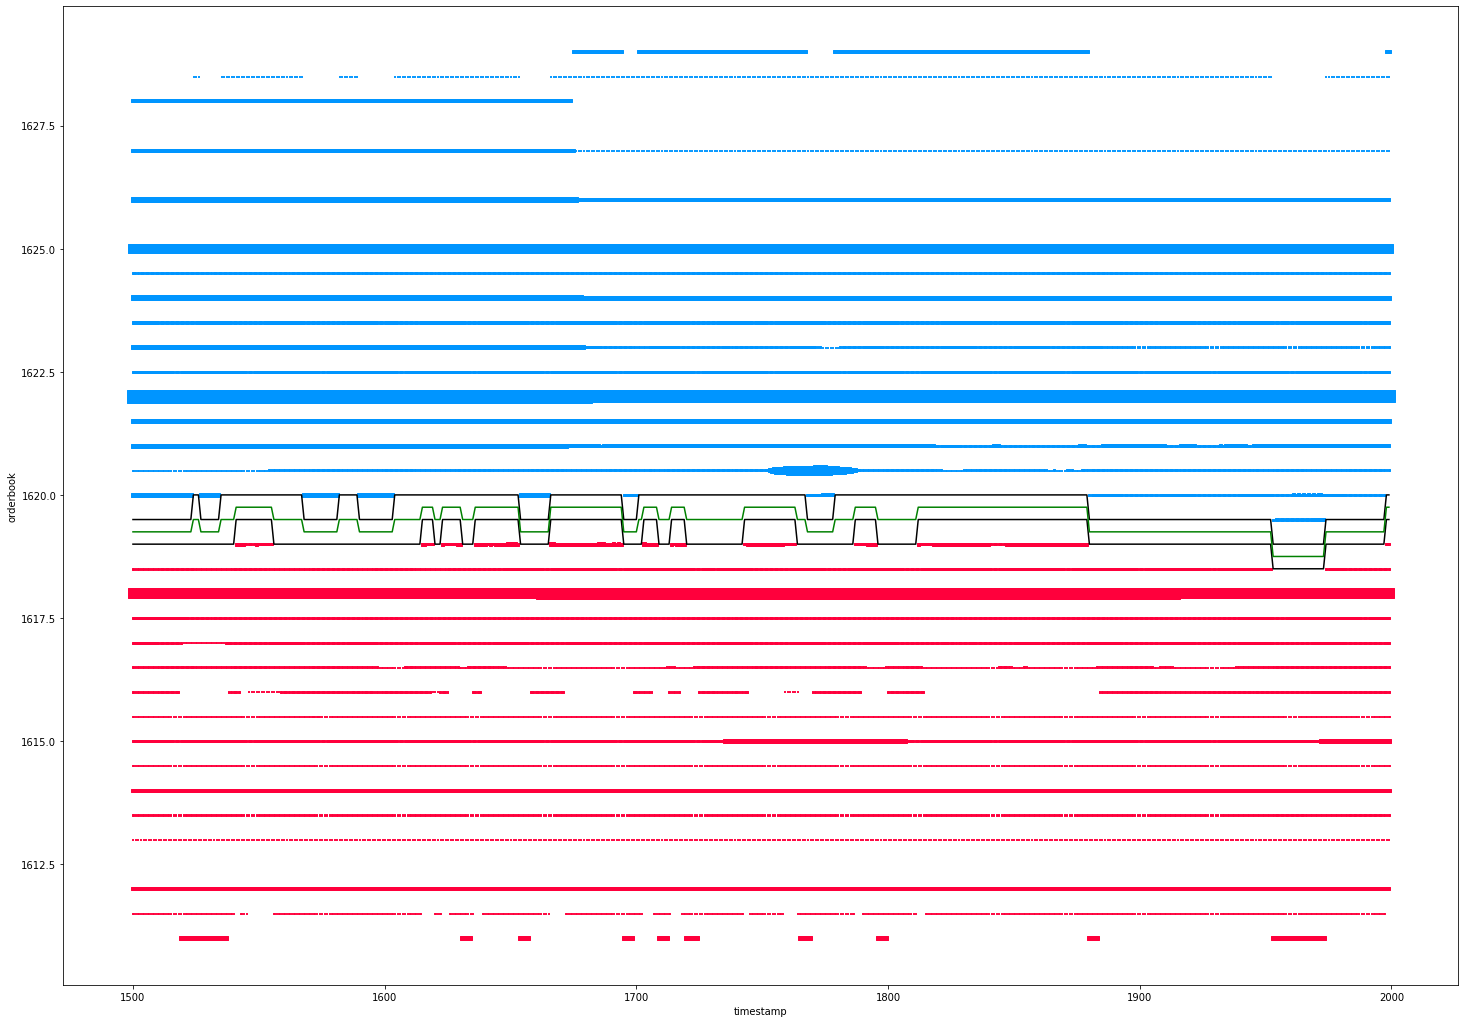

In [69]:
df0 = df.iloc[1500:2000]

fig, ax1 = plt.subplots(figsize=(25, 18))
for i in range(1,15):
    ax1.scatter(df0.index, df0['askRate%.0f' % i], s=df0['askSize%.0f' % i], c='#0095ff', marker='s')
    
for i in range(1,15):
    ax1.scatter(df0.index, df0['bidRate%.0f' % i], s=df0['bidSize%.0f' % i], c='#ff003c', marker='s')
    
ax1.plot(df0.index, df0.askRate0, c='black')
ax1.plot(df0.index, df0.bidRate0, c='black')
ax1.plot(df0.index, df0.mid, c='g')

ax1.set_xlabel('timestamp')
ax1.set_ylabel('orderbook')
plt.show()

In [12]:
%%time
signals = ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8', 'sig11', 'sig13']

model = LinearRegression(fit_intercept=False, normalize=False)
plot_regression(df, signals, model=model, plot=False)

model = HuberRegressor(fit_intercept=False, epsilon=1.35)
plot_regression(df, signals, model=model, plot=False)

# model = RidgeCV(alphas=[1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06], cv=TimeSeriesSplit(n_splits=2), fit_intercept=False, normalize=False)
# plot_regression(df, signals, model=model, plot=False)

# model = LassoCV(alphas=[1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06], cv=TimeSeriesSplit(n_splits=2), fit_intercept=False, normalize=False)
# plot_regression(df, signals, model=model, plot=False)

# model = XGBRegressor(n_estimators=150, objective='reg:squarederror', booster='gbtree', learning_rate=0.04, gamma=0, subsample=0.4, colsample_bytree=0.5, max_depth=4, reg_lambda=1e3, nthreads=6)
model = XGBRegressor(n_estimators=175, objective='reg:squarederror', booster='gbtree', learning_rate=0.04, gamma=0.5, subsample=0.4, colsample_bytree=0.4, max_depth=5, min_child_weight=10.0, colsample_bylevel=0.25, reg_lambda=1000., nthreads=6)
plot_regression(df, signals, model=model, plot=False);

Model:       LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
Signal:      ['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8', 'sig11', 'sig13']
Train score: [0.02136 0.02596 0.02572]
Test score:  [0.02989 0.02471 0.02868]
R2 Total:    0.026397
Signal mean: [ 0.00227 -0.00538  0.00242 -0.46265  0.00369  0.00448 -0.00016  0.00002
  0.00413 -0.00011]
Coefficients CV:
0.09103659943800435	0.09044434715968577	0.02725323014344433 	-0.0001600945099097112	-0.00022765249334322918	0.018676483970011527	0.20603788123904276	-0.37684680428694717	0.011183391958505883	0.046325048112674155
0.06652700913181751	0.09950598189964717	0.0311489213776893  	-0.0005995196402017178	0.006357835354682765   	0.017468767041295043	0.310413267565801  	-0.4342187197912133 	0.00904898919951056 	0.052685535447884235
0.06593132649068666	0.09304219055401908	0.032031189080767825	-0.0007491876561816352	0.004723632163234799   	0.016035019438765452	0.2882637681436541 	-0.42759279416

array([0.02722, 0.02433, 0.02801])

In [28]:
print(signals)
model = HuberRegressor(fit_intercept=False, epsilon=1.35)
model.fit(df[signals], df.y)
print(r2_score(df.y, model.predict(df[signals])))
print(model.coef_)
pickle.dump(model, open('python/model.sav', 'wb'))

['sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8', 'sig11', 'sig13', 'sig15', 'sig16']
0.02646978349129614
[ 0.07526  0.07994  0.02562 -0.00059  0.00334  0.01196  0.29502 -0.22311
  0.00589  0.05629 -0.03086 -0.21938]


In [ ]:
df['sig_test'] = 
test_signal_full(df, 'sig_test', signals)